In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss
#from sklearn.metrics import jaccard_similarity_score
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import folium

%matplotlib inline

In [2]:
#Loading the dataset
url = "https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv"

df = pd.read_csv(url)
df.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [3]:
#Removing Unwanted Columns/features
df.drop(["OBJECTID", "INCKEY","COLDETKEY", "ADDRTYPE",
        "INTKEY","LOCATION","EXCEPTRSNCODE","EXCEPTRSNDESC", "COLLISIONTYPE",
        "PERSONCOUNT","PEDCOUNT","VEHCOUNT","JUNCTIONTYPE","SDOT_COLCODE","SDOT_COLDESC",
        "UNDERINFL","PEDROWNOTGRNT","SDOTCOLNUM","ST_COLCODE","ST_COLDESC",
         "SEGLANEKEY","CROSSWALKKEY","HITPARKEDCAR","INATTENTIONIND","REPORTNO","SEVERITYCODE.1",
         "PEDCYLCOUNT","SEVERITYDESC","INCDATE","INCDTTM","STATUS", "SPEEDING"],axis = 1, inplace = True)

In [4]:
#Renaming columns/features
df.rename(columns = {"X":"LONGITUDE","Y":"LATITUDE"}, inplace = True)

df.head()

,SEVERITYCODE,LONGITUDE,LATITUDE,WEATHER,ROADCOND,LIGHTCOND
0,2,-122.323148,47.703140,Overcast,Wet,Daylight
1,1,-122.347294,47.647172,Raining,Wet,Dark - Street Lights On
2,1,-122.334540,47.607871,Overcast,Dry,Daylight
3,1,-122.334803,47.604803,Clear,Dry,Daylight
4,2,-122.306426,47.545739,Raining,Wet,Daylight


# Bar Charts 

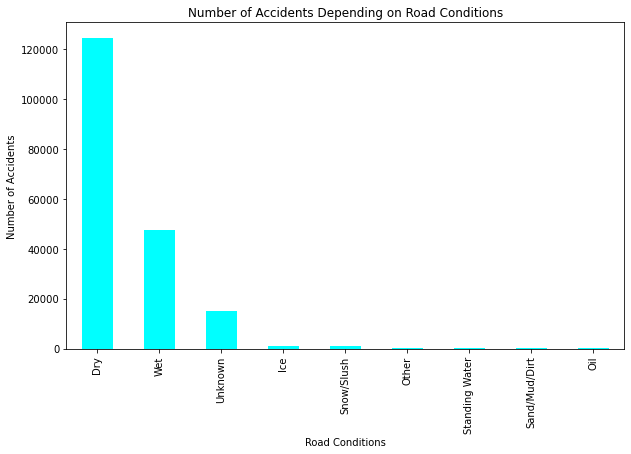

Dry               124510
Wet                47474
Unknown            15078
Ice                 1209
Snow/Slush          1004
Other                132
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64


In [5]:
#Bar chart for ROADCOND
df["ROADCOND"].value_counts().plot(kind = "bar", figsize = (10,6), color = "#00FFFF")

plt.xlabel("Road Conditions") # add to x-label to the plot
plt.ylabel("Number of Accidents") # add y-label to the plot
plt.title("Number of Accidents Depending on Road Conditions") # add title to the plot

plt.show()

print(df["ROADCOND"].value_counts())

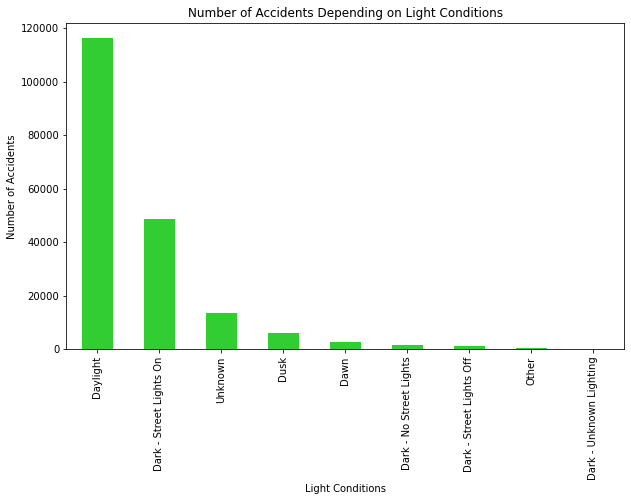

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64


In [6]:
#Bar chart for LIGHTCOND
df["LIGHTCOND"].value_counts().plot(kind = "bar", figsize = (10,6), color = "#32CD32")

plt.xlabel("Light Conditions") # add to x-label to the plot
plt.ylabel("Number of Accidents") # add y-label to the plot
plt.title("Number of Accidents Depending on Light Conditions") # add title to the plot

plt.show()

print(df["LIGHTCOND"].value_counts())

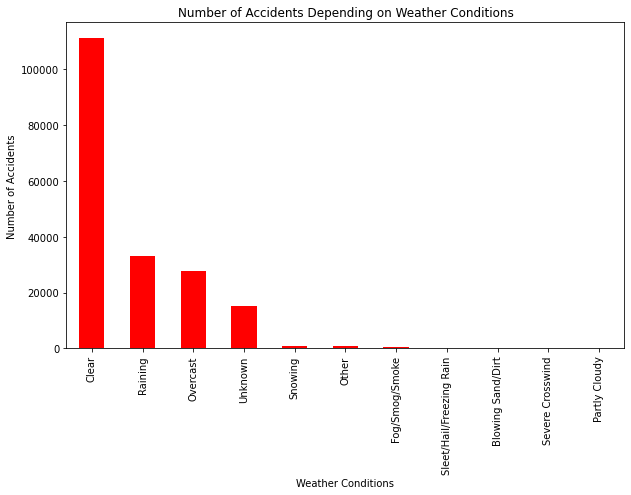

Clear                       111135
Raining                      33145
Overcast                     27714
Unknown                      15091
Snowing                        907
Other                          832
Fog/Smog/Smoke                 569
Sleet/Hail/Freezing Rain       113
Blowing Sand/Dirt               56
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64


In [7]:
#Bar chart for WEATHER
df["WEATHER"].value_counts().plot(kind = "bar", figsize = (10,6), color = "#FF0000")

plt.xlabel("Weather Conditions") # add to x-label to the plot
plt.ylabel("Number of Accidents") # add y-label to the plot
plt.title("Number of Accidents Depending on Weather Conditions") # add title to the plot

plt.show()

print(df["WEATHER"].value_counts())

# Data Preprocessing 

In [8]:
df["SEVERITYCODE"].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

In [9]:
#Balancing our samples in SEVERITYCODE
df_severity_1 = df[df["SEVERITYCODE"] == 1].index
df_severity_2 = len(df[df["SEVERITYCODE"] == 2])

random_majority_indices = np.random.choice(df_severity_1, df_severity_2, replace = False)
df_severity_2_indices = df[df["SEVERITYCODE"] == 2].index
under_sample_indices = np.concatenate([df_severity_2_indices, random_majority_indices])

under_sample = df.loc[under_sample_indices]

print(len(random_majority_indices)) #this shows that 1 (136,485) has under sampled to (58,188) same as 2

58188


In [10]:
#This code encodes the data from string into numbers
RoadCond = [("Dry",1),("Wet",2),("Ice",3),("Snow/Slush",4),("Standing Water",5),("Sand/Mud/Dirt",6),("Oil",7),("Other",8),("Unknown",9)]
for tuples in RoadCond:
    under_sample["ROADCOND"].replace(tuples[0],tuples[1], inplace = True)

LightCon = [("Daylight", 1),("Dark - Street Lights On",2),("Unknown",3),("Dusk",4),("Dawn",5),
            ("Dark - No Street Lights",6),("Dark - Street Lights Off",7),("Other",8),("Dark - Unknown Lighting", 9)]
for tuples in LightCon:
    under_sample["LIGHTCOND"].replace(tuples[0],tuples[1],inplace = True)
    
Weather = [("Clear",1),("Raining",2),("Overcast",3),("Snowing",4),("Fog/Smog/Smoke",5),("Sleet/Hail/Freezing Rain",6),
           ("Blowing Sand/Dirt",7),("Severe Crosswind",8),("Partly Cloudy",9),("Unknown",10),("Other",11)]
for tuples in Weather:
    under_sample["WEATHER"].replace(tuples[0],tuples[1],inplace = True)



In [11]:
under_sample.head()

,SEVERITYCODE,LONGITUDE,LATITUDE,WEATHER,ROADCOND,LIGHTCOND
0,2,-122.323148,47.703140,3.0,2.0,1.0
4,2,-122.306426,47.545739,2.0,2.0,1.0
7,2,-122.320780,47.614076,1.0,1.0,1.0
9,2,-122.384700,47.528475,1.0,1.0,1.0
14,2,-122.317414,47.664028,1.0,1.0,2.0


In [12]:
#Firstly I'm naming the X and y variables
X = under_sample[["WEATHER","ROADCOND","LIGHTCOND"]].values
y = under_sample[["SEVERITYCODE"]].values

#Normalising the data
X = preprocessing.StandardScaler().fit(X).transform(X.astype(int))
X[0:5]

array([[ 0.40714795,  0.11763833, -0.57105335],
       [-0.040265  ,  0.11763833, -0.57105335],
       [-0.48767794, -0.40598564, -0.57105335],
       [-0.48767794, -0.40598564, -0.57105335],
       [-0.48767794, -0.40598564,  0.38591064]])

In [13]:
#Train/Test splitting the data
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape,y_test.shape)

Training set shape: (81463, 3) (81463, 1)
Test set: (34913, 3) (34913, 1)


# K-Nearest-Neighbours

In [14]:
#K-Nearest-Neighbours
K = 10
neigh = KNeighborsClassifier(n_neighbors = K).fit(X_train, y_train)
neigh

<ipython-input-14-8bf473ef1aed>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  neigh = KNeighborsClassifier(n_neighbors = K).fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=10)

In [15]:
#The predictions
yhat_KNN = neigh.predict(X_test)
yhat_KNN[0:5]

array([2, 1, 1, 2, 1])

In [16]:
print("The accuracy of KNN using f1 score is: ",f1_score(y_test, yhat_KNN, average ="macro"))
print("The accuracy score of the Test set is: ",metrics.accuracy_score(y_test,yhat_KNN))

The accuracy of KNN using f1 score is:  0.5394322288108606
The accuracy score of the Test set is:  0.5408587059261593


# The code below checks the optimum K value but the data is too large for my computer to run this instantly!

In [17]:
#Ks = 10
#mean_acc = np.zeros((Ks - 1))
#std_acc = np.zeros((Ks - 1))

#for num in range(1,Ks):
#    neigh = KNeighborsClassifier(n_neighbors = num).fit(X_train,y_train)
#    yhat2 = neigh.predict(X_test)
#    mean_acc[num - 1] = metrics.accuracy_score(y_test,yhat2)
#    std_acc[num -1] = np.std(yhat == y_test)/np.sqrt(yhat.shape[0])
#    
#print("The Best accuracy is: ",mean_acc.max(),"and the optimum K is", mean_acc.argmax()+1)


# Decision Tree

In [18]:
#Decision Tree
Road_acc = DecisionTreeClassifier(criterion = "entropy", max_depth = 6)
Road_acc

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [19]:
Road_acc.fit(X_train, y_train)

#The predictions
yhat_tree = Road_acc.predict(X_test)
yhat_tree[0:5]

array([2, 1, 2, 1, 1])

In [20]:
#Checking the accuracy
print("The f1 score of the Decision Tree is: ", f1_score(y_test, yhat_tree, average = "macro"))
print("The accuracy score of the Tree is: ", metrics.accuracy_score(y_test,yhat_tree))

The f1 score of the Decision Tree is:  0.5393107756975366
The accuracy score of the Tree is:  0.5614813966144416


# Logistic Regression

In [21]:
#Logistic Regression

LogReg = LogisticRegression(C = 0.01, solver = "liblinear").fit(X_train, y_train)
LogReg

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(C=0.01, solver='liblinear')

In [22]:
LogReg.fit(X_train, y_train)
#Predicting yhat_lr
yhat_lr = LogReg.predict(X_test)
print(yhat_lr[0:5])

[1 2 1 2 2]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [23]:
#Predicting X_test using probability
yhat_proba = LogReg.predict_proba(X_test)
print(yhat_proba[0:5])

[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


In [24]:
#Printing the accuracy scores of the Logistic Regression model
print("The accuracy score of the Logistic Regression is: ", metrics.accuracy_score(y_test,yhat_lr))
print ("The f1 score accuracy of the Logistic Regression is: ", f1_score(y_test, yhat_lr, average = "macro"))
print("The log-loss accuracy of the Logistic Regression is: ", log_loss(y_test, yhat_proba))

The accuracy score of the Logistic Regression is:  0.46401054048635176
The f1 score accuracy of the Logistic Regression is:  0.4479441599226551
The log-loss accuracy of the Logistic Regression is:  0.6925526274089825


# Foliums

In [25]:
#Replacing missing values 
df["LONGITUDE"].replace(np.nan,df["LONGITUDE"].mean(), inplace = True)
df["LATITUDE"].replace(np.nan, df["LATITUDE"].mean(), inplace = True)

In [26]:
#Displaying where the road accidents occured
longitude = df["LONGITUDE"][0:100]
latitude = df["LATITUDE"][0:100]

world_map = folium.Map()

Seattle = folium.map.FeatureGroup()
for y,x in zip(latitude,longitude):
    Seattle.add_child(folium.features.CircleMarker(location = [y,x],radius = 5, color ="blue",fill_color = "blue"))

world_map.add_child(Seattle)